# MNIST Digit Classification with Convolutional Neural Network (CNN)

**Discipline(s):** Computer Vision, Deep Learning

colab에서 돌릴 경우, 런타임 유형을 GPU로 변경해주세요.

## 1. Import Statements

---



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

## 2. Data Preprocessing

---



The first step is to preprocess our data.

In [2]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets

print("Training Images:", X_train.shape)  # [60000, 28, 28]
print("Testing Images:", X_test.shape)    # [10000, 28, 28]
print("Training Labels:", y_train.shape)  # [60000]
print("Test Labels:", y_test.shape)       # [10000]

Training Images: torch.Size([60000, 28, 28])
Testing Images: torch.Size([10000, 28, 28])
Training Labels: torch.Size([60000])
Test Labels: torch.Size([10000])


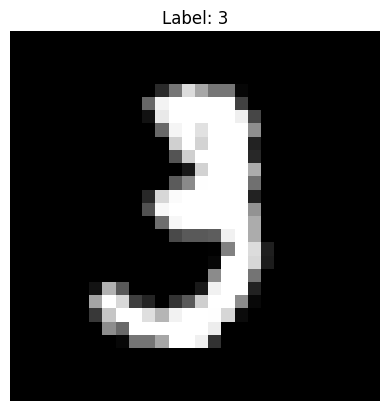

In [6]:
plt.imshow(X_train[10], cmap='gray')
plt.title(f"Label: {y_train[10].item()}")
plt.axis('off')
plt.show()

## 3. Convolutional Neural Network (CNN)

---



### 3.1. Define the Model

We then have to define our convolutional neural network.

In [7]:
# CNN 모델 정의 -> 차원이 어떻게 될지 생각하면서 코드 빈칸을 채워주세요.
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            ## 첫번째 Conv 블록 ##
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),  # (1,28,28) → (32,28,28)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            ## 두번째 Conv 블록 ##
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # (32,28,28) → (64,28,28)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64,28,28) → (64,14,14)

            ## 세번째 Conv 블록 ##
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # (64,14,14) → (128,14,14)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128,14,14) → (128,7,7)

            # flatten 과정
            nn.Flatten(),  # (128,7,7) → (128*7*7)=6272

            ## Fully Connected Layers ##
            nn.Linear(128*7*7, 256),  # (6272) → (256)
            nn.ReLU(),
            nn.Dropout(0.5),  # 과적합 방지 위해 50% 랜덤 뉴런 끄기
            nn.Linear(256, 128),  # (256) → (128)
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 10)  # (128) → (10 클래스)
        )

    def forward(self, x):
        return self.net(x)

In [8]:
# 모델 준비
model = SimpleCNN().to(DEVICE)

Once our model is defined, we can compile it using the Adam optimizer and the categorical cross-entropy loss function.

In [9]:
criterion = nn.CrossEntropyLoss()   # MNIST는 다중 클래스 분류 문제
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### 3.2. Train the Model

In [10]:
def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (output.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [11]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item() * y.size(0)
            correct += (output.argmax(dim=1) == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [12]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.2635, Train Acc: 0.9197 | Test Loss: 0.0452, Test Acc: 0.9861
[Epoch 2] Train Loss: 0.1091, Train Acc: 0.9707 | Test Loss: 0.0369, Test Acc: 0.9893
[Epoch 3] Train Loss: 0.0840, Train Acc: 0.9779 | Test Loss: 0.0322, Test Acc: 0.9907
[Epoch 4] Train Loss: 0.0705, Train Acc: 0.9819 | Test Loss: 0.0341, Test Acc: 0.9897
[Epoch 5] Train Loss: 0.0594, Train Acc: 0.9843 | Test Loss: 0.0319, Test Acc: 0.9898
[Epoch 6] Train Loss: 0.0524, Train Acc: 0.9862 | Test Loss: 0.0329, Test Acc: 0.9908
[Epoch 7] Train Loss: 0.0503, Train Acc: 0.9864 | Test Loss: 0.0279, Test Acc: 0.9918
[Epoch 8] Train Loss: 0.0405, Train Acc: 0.9893 | Test Loss: 0.0289, Test Acc: 0.9923
[Epoch 9] Train Loss: 0.0394, Train Acc: 0.9887 | Test Loss: 0.0250, Test Acc: 0.9932
[Epoch 10] Train Loss: 0.0333, Train Acc: 0.9907 | Test Loss: 0.0224, Test Acc: 0.9933


### 3.3. 시각화

Finally, we can plot the curves.

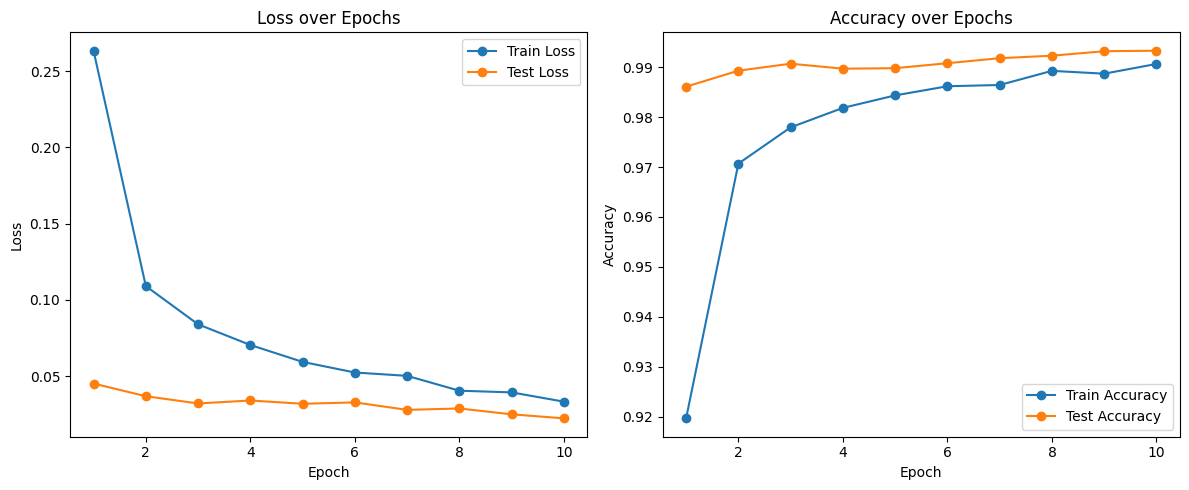

In [13]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [14]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

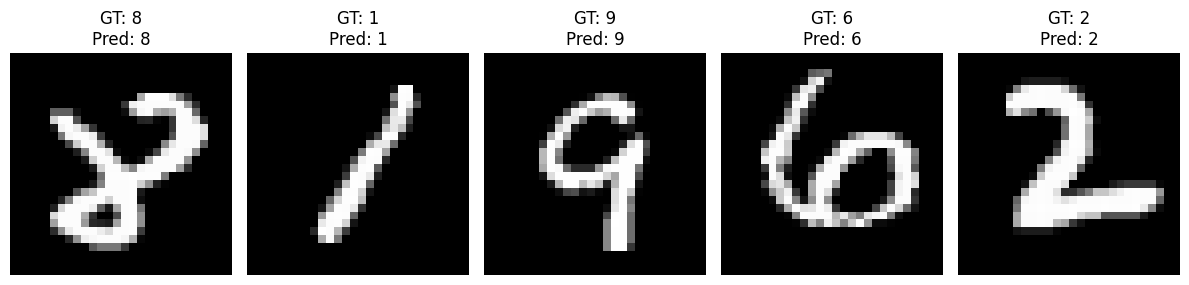

In [15]:
show_random_predictions(model, test_dataset, num_images=5)

## ResNet

In [16]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)


        # Skip connection: 채널 수가 다르면 1x1 Conv로 조정
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),  # 1x1 Conv
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # skip connection
        return self.relu(out)

In [18]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()

        ## stem block ##
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),  # (1,28,28) → (32,28,28)
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        ## residual blocks ##
        self.layer1 = ResidualBlock(32, 64)  # (32,28,28) → (64,14,14)
        self.layer2 = ResidualBlock(64, 128)  # (64,14,14) → (128,7,7)
        self.layer3 = ResidualBlock(128, 128)  # (128,7,7) → (128,7,7)

        ## global average pooling ##
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # (128,7,7) → (128,1,1)

        ## fully connected layers ##
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                      # (128,1,1) → (128)
            nn.Linear(128, 256),                # (128) → (256)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),                # (256) → (128)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)         # (128) → (10 클래스)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = self.fc_layers(x)
        return x

In [19]:
model = ResNetLike().to(DEVICE)

In [20]:
criterion = nn.CrossEntropyLoss()   # MNIST는 다중 클래스 분류 문제
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.4578, Train Acc: 0.8520 | Test Loss: 0.1638, Test Acc: 0.9494
[Epoch 2] Train Loss: 0.1307, Train Acc: 0.9643 | Test Loss: 0.1161, Test Acc: 0.9689
[Epoch 3] Train Loss: 0.0935, Train Acc: 0.9748 | Test Loss: 0.0648, Test Acc: 0.9804
[Epoch 4] Train Loss: 0.0768, Train Acc: 0.9791 | Test Loss: 0.0446, Test Acc: 0.9862
[Epoch 5] Train Loss: 0.0695, Train Acc: 0.9809 | Test Loss: 0.0947, Test Acc: 0.9748
[Epoch 6] Train Loss: 0.0591, Train Acc: 0.9839 | Test Loss: 0.0794, Test Acc: 0.9773
[Epoch 7] Train Loss: 0.0573, Train Acc: 0.9846 | Test Loss: 0.0310, Test Acc: 0.9906
[Epoch 8] Train Loss: 0.0476, Train Acc: 0.9872 | Test Loss: 0.0506, Test Acc: 0.9852
[Epoch 9] Train Loss: 0.0481, Train Acc: 0.9870 | Test Loss: 0.0285, Test Acc: 0.9915
[Epoch 10] Train Loss: 0.0446, Train Acc: 0.9877 | Test Loss: 0.0347, Test Acc: 0.9906


### 시각화

Finally, we can plot the curves.

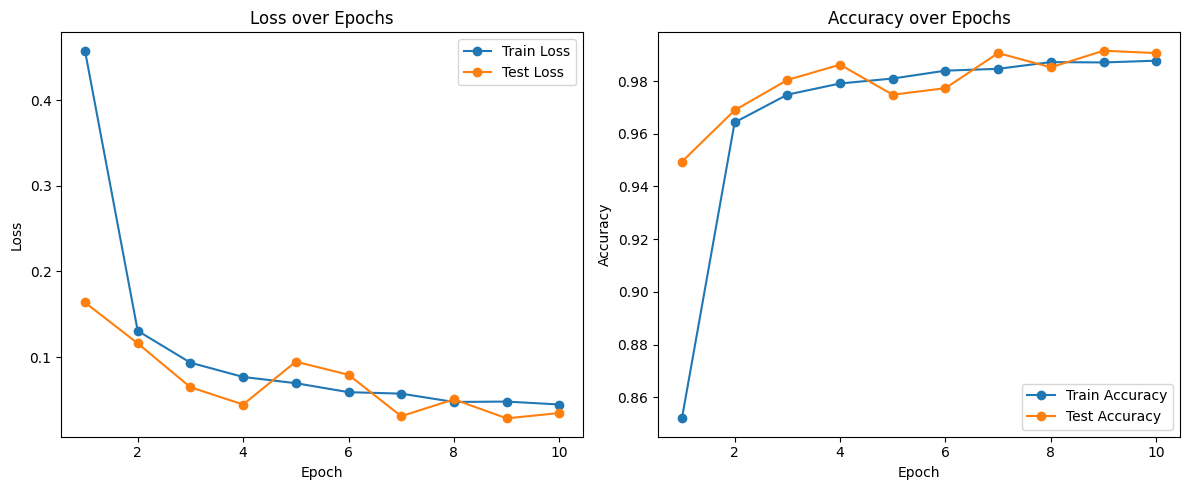

In [22]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [23]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

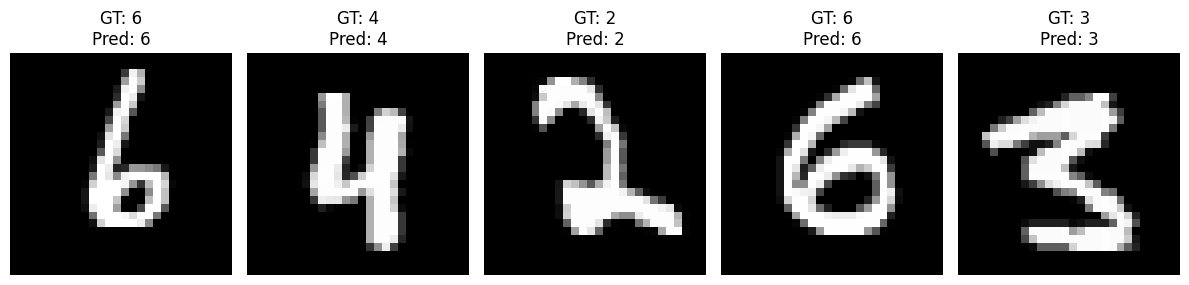

In [24]:
show_random_predictions(model, test_dataset, num_images=5)

# 다른 데이터셋으로도 진행해보기

## 데이터 불러오기

In [35]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 데이터셋 경로 설정
DATASET_DIR = '/content/drive/MyDrive/HAM10000'
IMAGES_DIR_1 = f"{DATASET_DIR}/HAM10000_images_part_1"
IMAGES_DIR_2 = f"{DATASET_DIR}/HAM10000_images_part_2"
METADATA_FILE = f"{DATASET_DIR}/HAM10000_metadata.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
import os

# 메타데이터 로드
metadata = pd.read_csv(METADATA_FILE)
print(metadata.head())

# 이미지 파일 경로 붙이기
def get_image_path(row):
    img_name = row['image_id'] + '.jpg'
    if os.path.exists(os.path.join(IMAGES_DIR_1, img_name)):
        return os.path.join(IMAGES_DIR_1, img_name)
    else:
        return os.path.join(IMAGES_DIR_2, img_name)

metadata['image_path'] = metadata.apply(get_image_path, axis=1)
print(metadata[['image_id', 'dx', 'image_path']].head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
       image_id   dx                                         image_path
0  ISIC_0027419  bkl  /content/drive/MyDrive/HAM10000/HAM10000_image...
1  ISIC_0025030  bkl  /content/drive/MyDrive/HAM10000/HAM10000_image...
2  ISIC_0026769  bkl  /content/drive/MyDrive/HAM10000/HAM10000_image...
3  ISIC_0025661  bkl  /content/drive/MyDrive/HAM10000/HAM10000_image...
4  ISIC_0031633  bkl  /content/drive/MyDrive/HAM10000/HAM10000_image...


In [37]:
# 라벨 정보 확인
print("클래스 분포:")
print(metadata['dx'].value_counts())

클래스 분포:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [38]:
from torch.utils.data import Dataset
from PIL import Image

# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])  # 문자열 라벨 → 숫자 라벨
print("라벨 인코딩 매핑:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# 커스텀 Dataset 클래스
class SkinDiseaseDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')  # RGB 이미지로 변환

        if self.transform:
            image = self.transform(image)
        return image, label

라벨 인코딩 매핑: {'akiec': np.int64(0), 'bcc': np.int64(1), 'bkl': np.int64(2), 'df': np.int64(3), 'mel': np.int64(4), 'nv': np.int64(5), 'vasc': np.int64(6)}


In [39]:
### 데이터 증강 및 DataLoader 구성 ###
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# 데이터 증강, 전처리
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# Train/Test 분리
train_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)

# Dataset 생성
train_dataset = SkinDiseaseDataset(train_df, transform=transform)
test_dataset = SkinDiseaseDataset(test_df, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

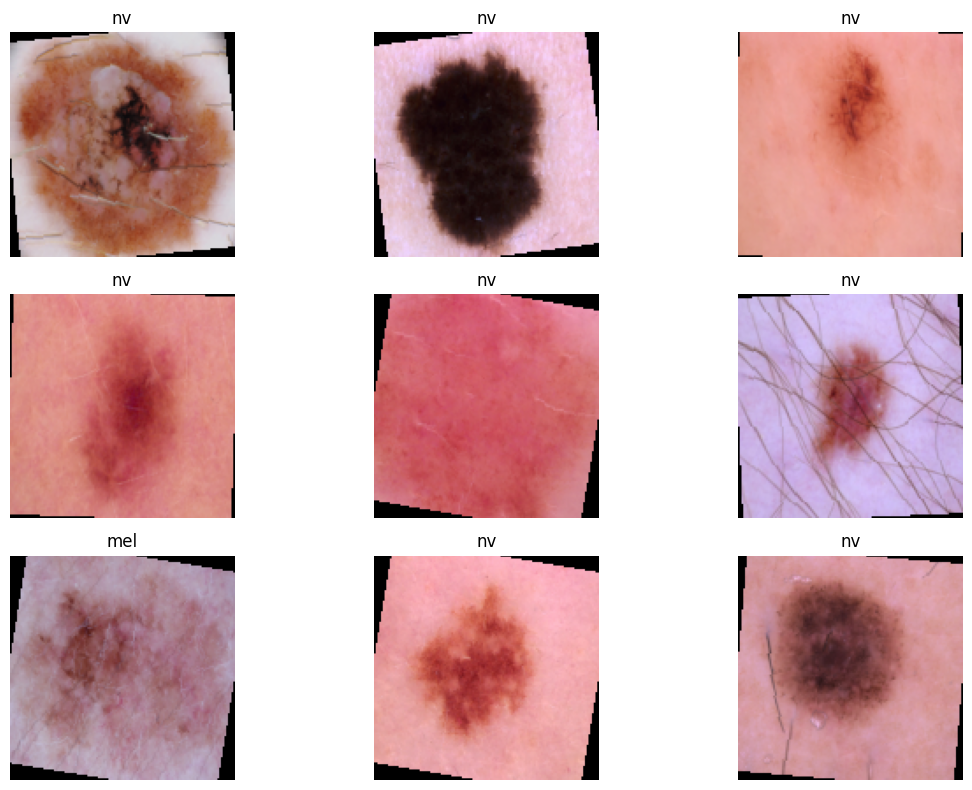

In [40]:
### 데이터 로딩 결과 시각화 ###
import matplotlib.pyplot as plt
import numpy as np

class_names = label_encoder.classes_
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 이미지 보여주기 함수
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # [C, H, W] → [H, W, C]
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # 정규화 해제
    img = np.clip(img, 0, 1)  # [0,1] 범위로 제한
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# 첫 배치에서 9개 이미지 시각화
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow(images[i], title=class_names[labels[i]])
plt.tight_layout()
plt.show()


## SimpleCNN

In [45]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        ## 첫 번째 Conv 블록 ##
        nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (3,128,128) → (32,128,128)
        nn.BatchNorm2d(32),
        nn.ReLU(),

        ## 두 번째 Conv 블록 ##
        nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (32,128,128) → (64,128,128)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  # (64,128,128) → (64,64,64)

        ## 세 번째 Conv 블록 ##
        nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (64,64,64) → (128,64,64)
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  # (128,64,64) → (128,32,32)

        # adaptive average pooling
        nn.AdaptiveAvgPool2d((1,1)),  # (128,32,32) → (128,1,1)
        # flatten
        nn.Flatten(),  # (128,1,1) → (128)

        ## Fully Connected Layers ##
        nn.Linear(128, 256),  # (128) → (256)
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 128),  # (256) → (128)
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 7)     # (128) → (7 클래스)
    )

  def forward(self, x):
    return self.net(x)

In [46]:
import torch.optim as optim

# 하이퍼파라미터
LEARNING_RATE = 0.0001
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델, 손실함수, 옵티마이저 준비
model = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [47]:
def train(model, loader):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, loader):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [48]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 1.1944, Train Acc: 0.6382 | Test Loss: 0.9480, Test Acc: 0.6695
[Epoch 2] Train Loss: 0.9708, Train Acc: 0.6660 | Test Loss: 0.8977, Test Acc: 0.6695
[Epoch 3] Train Loss: 0.9348, Train Acc: 0.6700 | Test Loss: 0.8624, Test Acc: 0.6750
[Epoch 4] Train Loss: 0.8972, Train Acc: 0.6757 | Test Loss: 0.8473, Test Acc: 0.6825
[Epoch 5] Train Loss: 0.8804, Train Acc: 0.6795 | Test Loss: 0.8365, Test Acc: 0.6940
[Epoch 6] Train Loss: 0.8677, Train Acc: 0.6817 | Test Loss: 0.8258, Test Acc: 0.6900
[Epoch 7] Train Loss: 0.8591, Train Acc: 0.6825 | Test Loss: 0.8052, Test Acc: 0.6995
[Epoch 8] Train Loss: 0.8486, Train Acc: 0.6893 | Test Loss: 0.8068, Test Acc: 0.6990
[Epoch 9] Train Loss: 0.8390, Train Acc: 0.6930 | Test Loss: 0.8068, Test Acc: 0.7024
[Epoch 10] Train Loss: 0.8302, Train Acc: 0.6917 | Test Loss: 0.7898, Test Acc: 0.7154


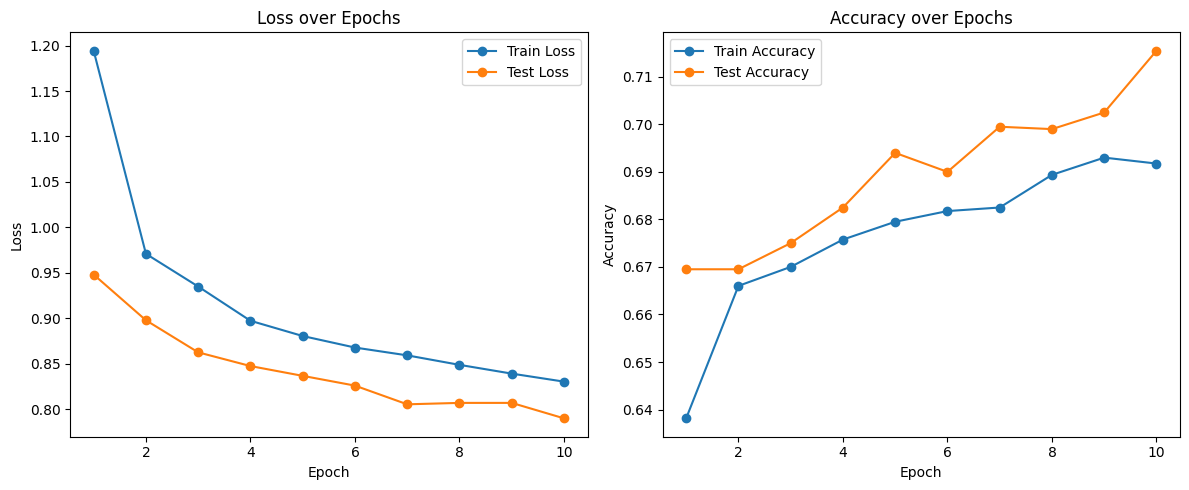

In [49]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
import random
import matplotlib.pyplot as plt
import torch

def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img = images[i].cpu().permute(1, 2, 0)  # (C,H,W) → (H,W,C)
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std + mean  # 정규화 해제
        img = torch.clamp(img, 0, 1)  # 값 범위 [0,1]로 제한
        plt.imshow(img)
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

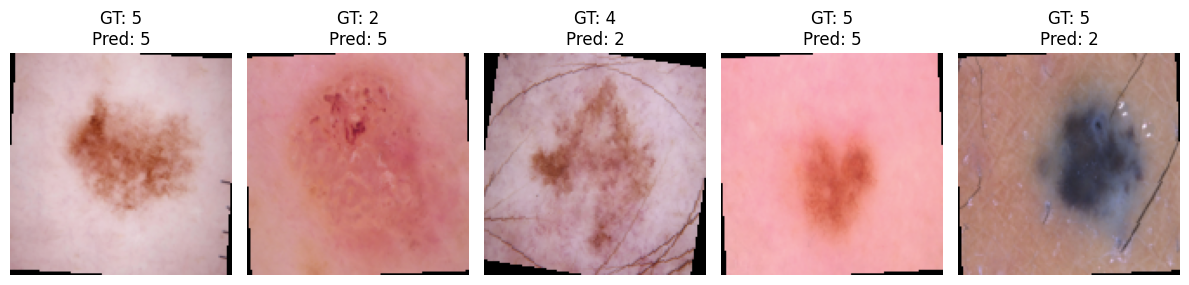

In [53]:
show_random_predictions(model, test_dataset, num_images=5)

## ResNet

In [56]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()

        ## stem block ##
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # (3,224,224) → (32,224,224)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # (32,224,224) → (32,112,112)
        )

        ## residual blocks ##
        self.layer1 = ResidualBlock(32, 64)   # (32,112,112) → (64,56,56)
        self.layer2 = ResidualBlock(64, 128)  # (64,56,56) → (128,28,28)
        self.layer3 = ResidualBlock(128, 128)                  # (128,28,28) → (128,28,28)

        # adaptive average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # (128,28,28) → (128,1,1)

        ## Fully Connected Layers ##
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                 # (128,1,1) → (128)
            nn.Linear(128, 256),          # (128) → (256)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),          # (256) → (128)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 7)             # (128) → (7 클래스)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = self.fc_layers(x)
        return x

In [57]:
import torch.optim as optim

# 하이퍼파라미터
LEARNING_RATE = 0.0001
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델, 손실함수, 옵티마이저
model = ResNetLike().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [58]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch [1/10] Train Loss: 1.1205, Train Acc: 0.6343 | Test Loss: 0.9072, Test Acc: 0.6695
Epoch [2/10] Train Loss: 0.9464, Train Acc: 0.6648 | Test Loss: 0.8830, Test Acc: 0.6775
Epoch [3/10] Train Loss: 0.8992, Train Acc: 0.6779 | Test Loss: 0.8223, Test Acc: 0.6875
Epoch [4/10] Train Loss: 0.8624, Train Acc: 0.6812 | Test Loss: 0.8080, Test Acc: 0.6955
Epoch [5/10] Train Loss: 0.8512, Train Acc: 0.6885 | Test Loss: 0.7839, Test Acc: 0.7109
Epoch [6/10] Train Loss: 0.8231, Train Acc: 0.6945 | Test Loss: 0.7816, Test Acc: 0.7124
Epoch [7/10] Train Loss: 0.8036, Train Acc: 0.7066 | Test Loss: 0.7507, Test Acc: 0.7199
Epoch [8/10] Train Loss: 0.7908, Train Acc: 0.7093 | Test Loss: 0.7371, Test Acc: 0.7304
Epoch [9/10] Train Loss: 0.7804, Train Acc: 0.7147 | Test Loss: 0.7384, Test Acc: 0.7239
Epoch [10/10] Train Loss: 0.7625, Train Acc: 0.7227 | Test Loss: 0.7269, Test Acc: 0.7289


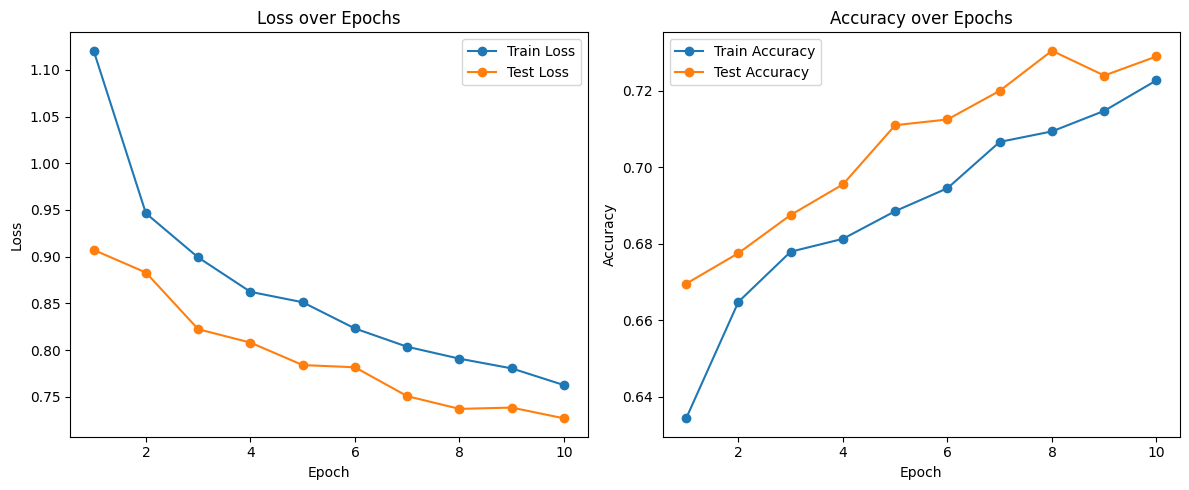

In [59]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

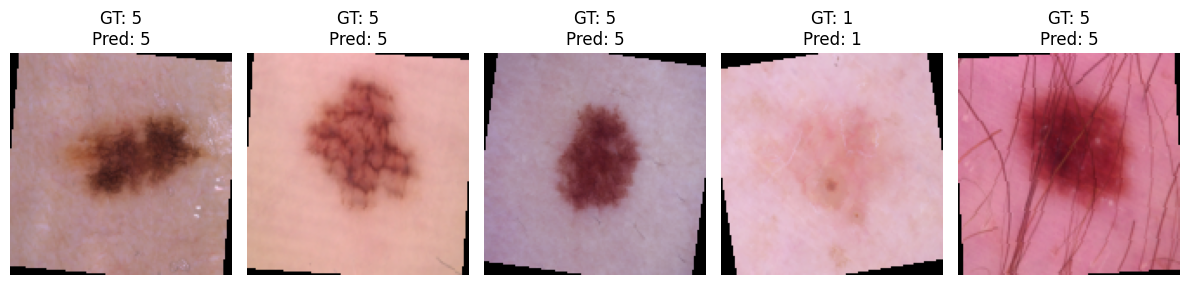

In [60]:
show_random_predictions(model, test_dataset, num_images=5)